In [1]:
import numpy as np

import oracles
from optimization import barrier_method_lasso

import random

from tqdm.notebook import tqdm

import zipfile
import wget
import os
from libsvm.svmutil import *
from sklearn.datasets import load_svmlight_file

np.random.seed(10)
random.seed(10)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 7)

In [2]:
def startPoint(d):
    return np.full(d, 0), np.full(d, 1)

# Эксперимент

In [3]:
GAMMAS = [10 * _ for _ in range(1, 11)]
EPS_INNERS = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
LAMBDAS = [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 7, 10]

In [4]:
filenames = ['w8a']
try:
    os.makedirs('data')
    for filename in filenames:
        print(filename)
        wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/' + filename, filename)
        os.replace(filename, 'data/' + filename)
except:
    pass
    
filenames = ['data/' + name for name in filenames]

In [5]:
HISTORY = {'gamma':{},
           'tol_inner':{},
           'lambda':{}
          }

ldg = oracles.lasso_duality_gap

## Пункт a

In [6]:
X, y = load_svmlight_file(filenames[0])
m, n = X.shape
x_0, u_0 = startPoint(n)
for gamma in tqdm(GAMMAS, 'gamma'):
    _, msg, history = barrier_method_lasso(X, y, 2.0, x_0, u_0, lasso_duality_gap=ldg,
                                                tolerance_inner=1e-8, gamma=gamma, trace=True)
    if msg == 'success':
        HISTORY['gamma'][gamma] = history
        
for eps in tqdm(EPS_INNERS, 'inner tolerance'):
    _, msg, history = barrier_method_lasso(X, y, 2.0, x_0, u_0, lasso_duality_gap=ldg,
                                                tolerance_inner=eps, gamma=10, trace=True)
    if msg == 'success':
        HISTORY['tol_inner'][eps] = history
        
for lambd in tqdm(LAMBDAS, 'lambda'):
    _, msg, history = barrier_method_lasso(X, y, lambd, x_0, u_0, lasso_duality_gap=ldg,
                                                tolerance_inner=1e-8, gamma=10, trace=True)
    if msg == 'success':
        HISTORY['lambda'][lambd] = history      

gamma:   0%|          | 0/10 [00:00<?, ?it/s]

inner tolerance:   0%|          | 0/11 [00:00<?, ?it/s]

lambda:   0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
def plot(LIST_OF, name, fs=15):
    fig, axes = plt.subplots(nrows=2, figsize=(18, 20))

    for elem in LIST_OF:
        h = HISTORY[name][elem]
        axes[0].plot(np.arange(len(h['time'])), np.log(h['duality_gap']), label=name + '={0}'.format(elem), linewidth=2)
        axes[1].plot(h['time'], np.log(h['duality_gap']), label=name + '={0}'.format(elem), linewidth=2)


    axes[0].set_xlabel('iteration', fontsize=fs)
    axes[0].set_title('Duality Gap - Iteration', fontsize=fs)

    axes[1].set_xlabel('time (seconds)', fontsize=fs)
    axes[1].set_title('Duality Gap - Real Time', fontsize=fs)

    for ax in axes:
        ax.set_ylabel('duality gap', fontsize=fs)
        ax.legend(fontsize=fs)
        ax.grid()

    plt.show()
    fig.savefig(name + '.png') 

### Для `gamma`

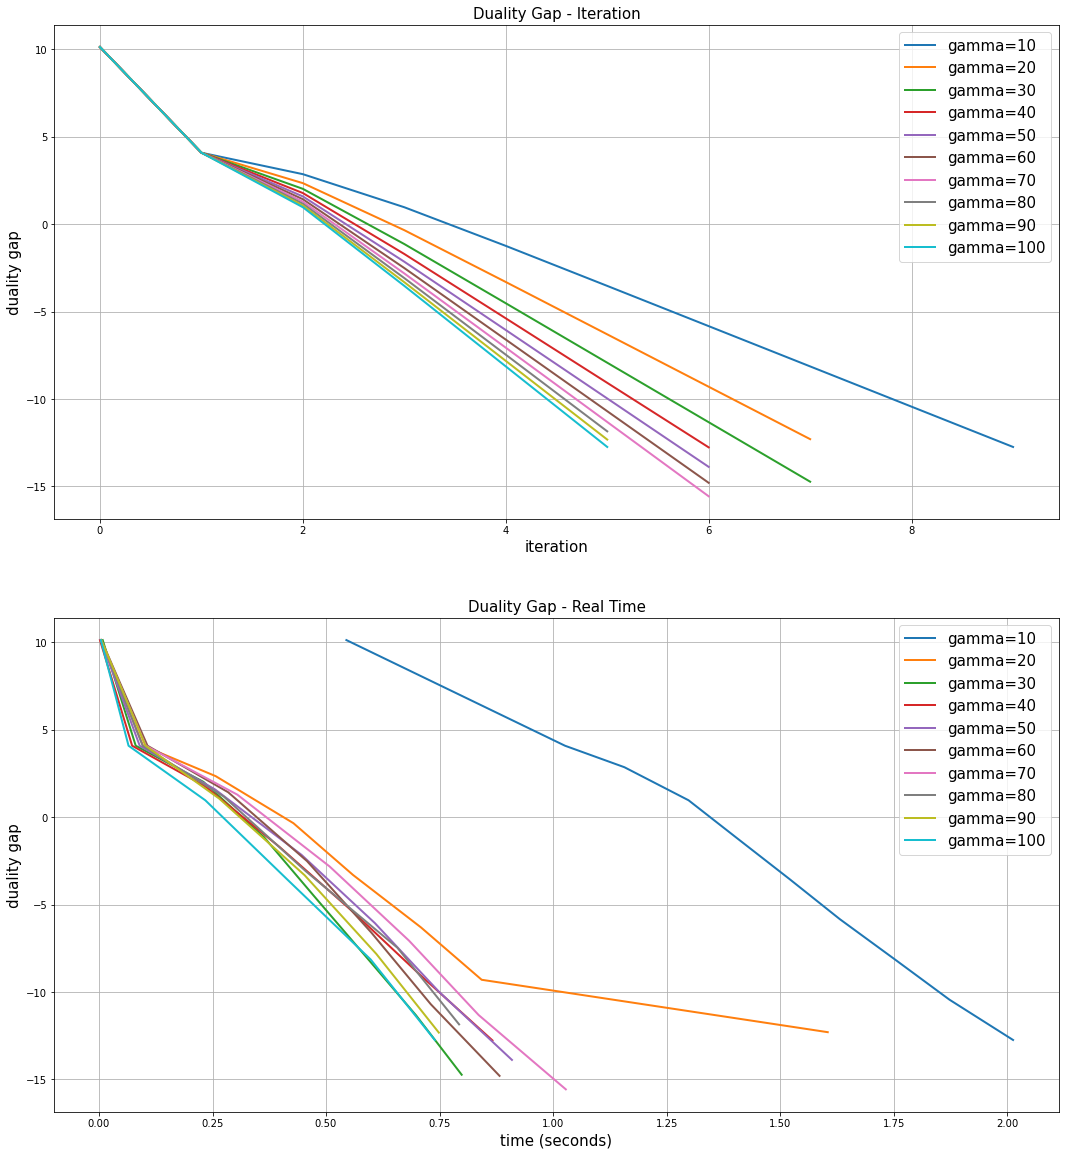

In [8]:
plot(GAMMAS, 'gamma')

### Для `tol_inner`

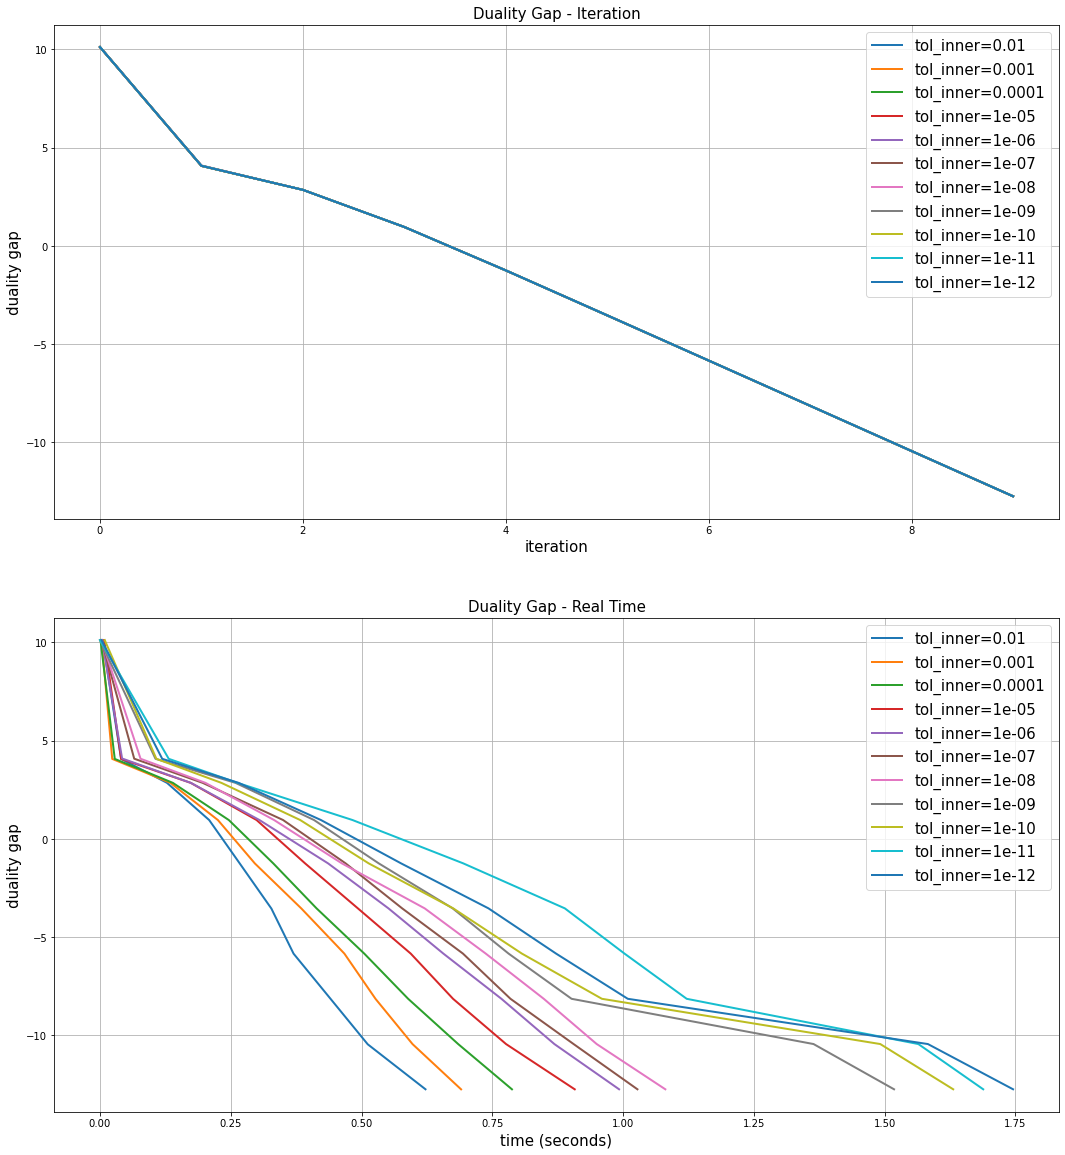

In [9]:
plot(EPS_INNERS, 'tol_inner')

## Пункт b

### Для `lambda`

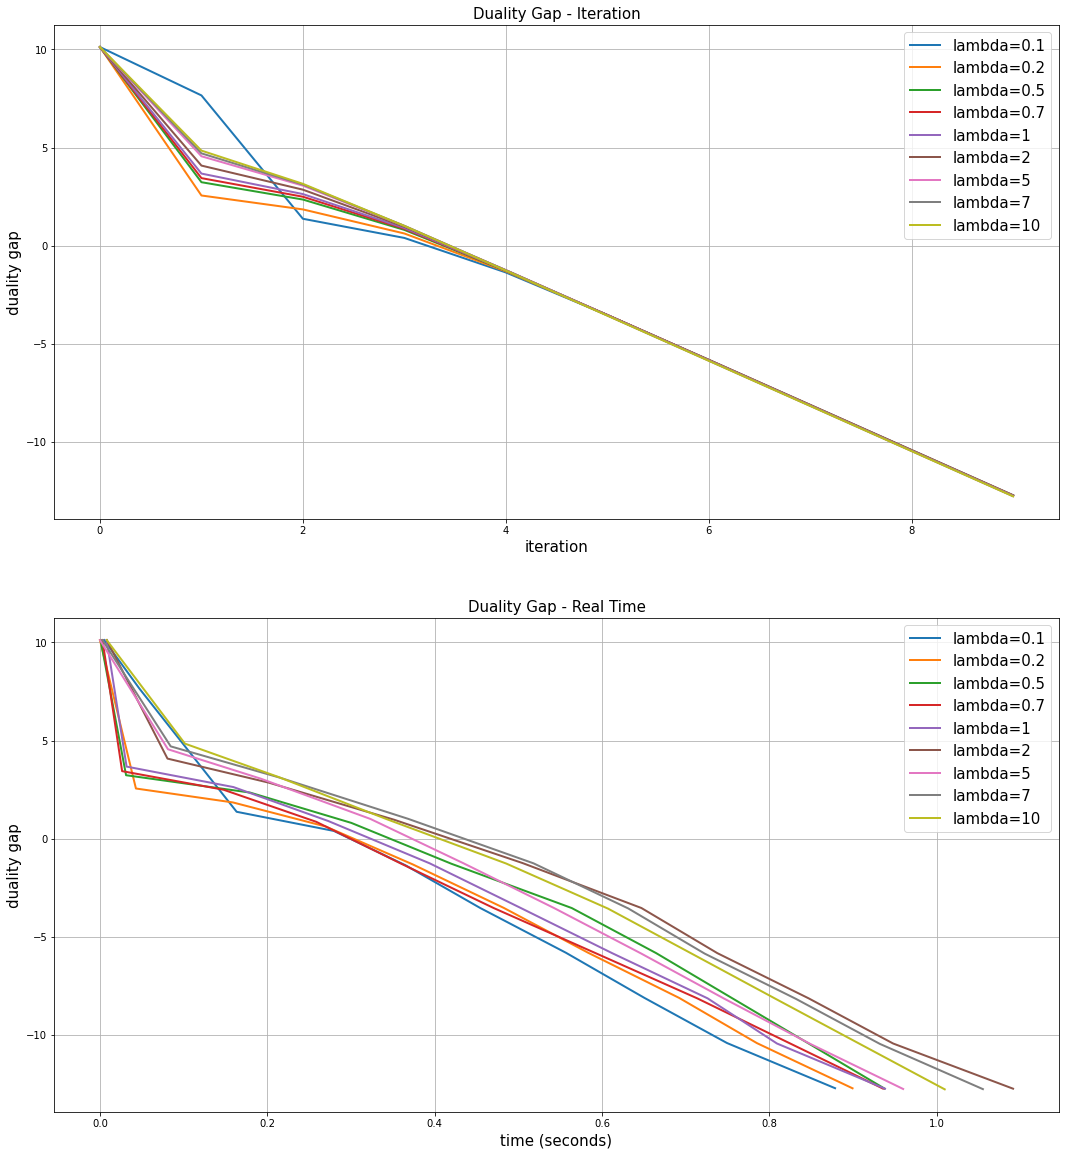

In [10]:
plot(LAMBDAS, 'lambda')

### Для различных `m`

In [11]:
shapes_m, shapes_n = {}, {}
Ms = [100, 500, 1000, 2500, 5000, 10000]

In [12]:
n = 1000
for m in tqdm(Ms, 'm'):
    X = np.random.normal(size=(m, n))
    y = np.random.normal(size=(m,))
    x_0, u_0 = startPoint(n)
    _, msg, history = barrier_method_lasso(X, y, 2, x_0, u_0, tolerance_inner=1e-8, gamma=10, trace=True)
    if msg == 'success':
        shapes_m[m] = history
del X, y

m:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

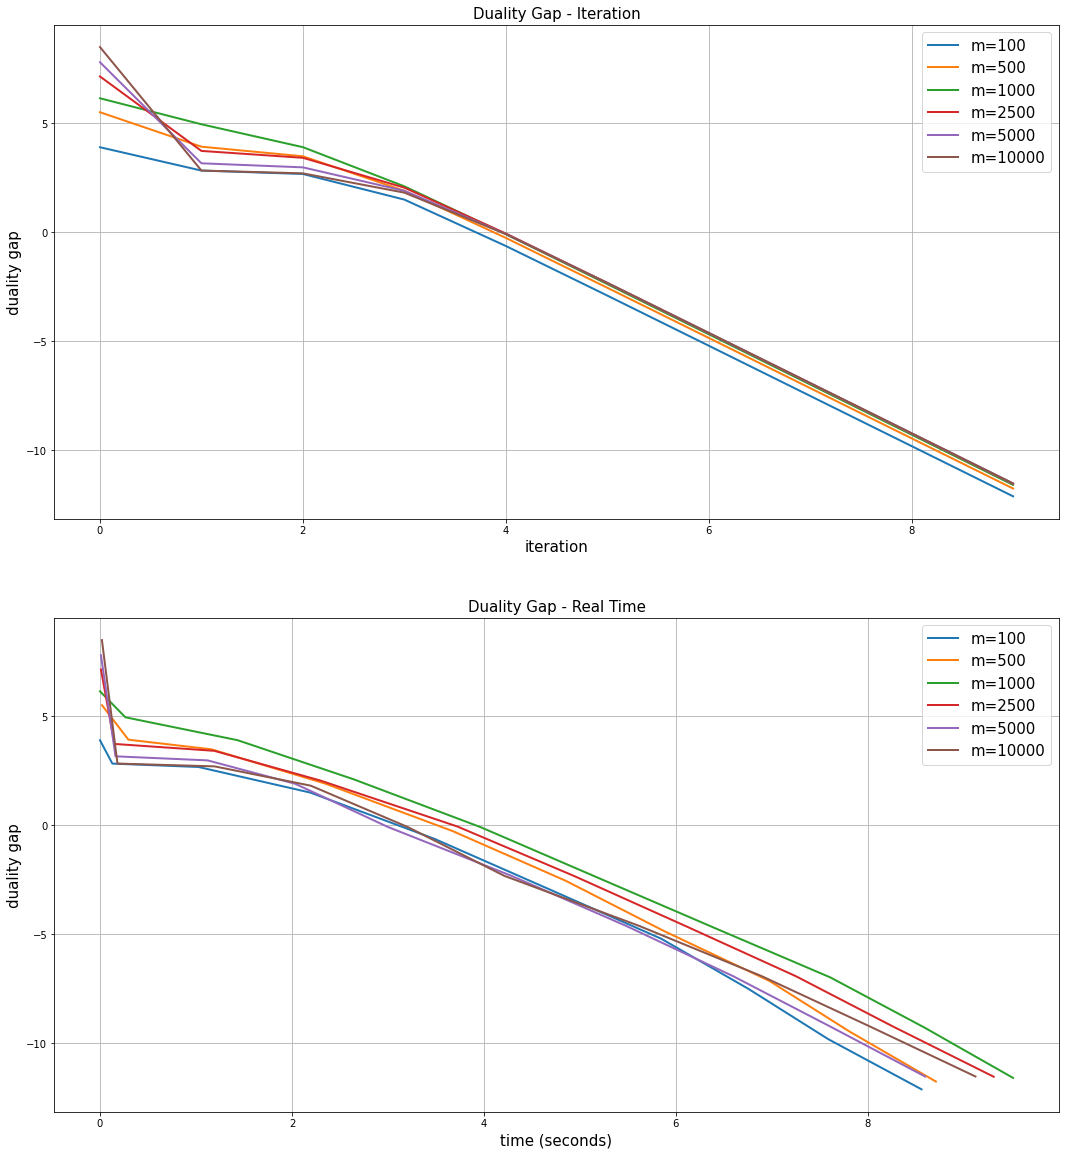

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(18, 20))
fs = 15

for m in tqdm(Ms):
    h = shapes_m[m]
    axes[0].plot(np.arange(len(h['time'])), np.log(h['duality_gap']), label='m={0}'.format(m), linewidth=2)
    axes[1].plot(h['time'], np.log(h['duality_gap']), label='m={0}'.format(m), linewidth=2)

axes[0].set_xlabel('iteration', fontsize=fs)
axes[0].set_title('Duality Gap - Iteration', fontsize=fs)

axes[1].set_xlabel('time (seconds)', fontsize=fs)
axes[1].set_title('Duality Gap - Real Time', fontsize=fs)

for ax in axes:
    ax.set_ylabel('duality gap', fontsize=fs)
    ax.legend(fontsize=fs)
    ax.grid()

plt.show()
fig.savefig('m.png') 

### Для различных `n`

In [18]:
m = 10000
Ns = [100, 500, 1000, 2500, 5000]
for n in tqdm(Ns, 'n'):
    X = np.random.normal(size=(m, n))
    y = np.random.normal(size=(m,))
    x_0, u_0 = startPoint(n)
    _, msg, history = barrier_method_lasso(X, y, 2, x_0, u_0, tolerance_inner=1e-8, gamma=10, trace=True)
    if msg == 'success':
        shapes_n[n] = history
del X, y

n:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

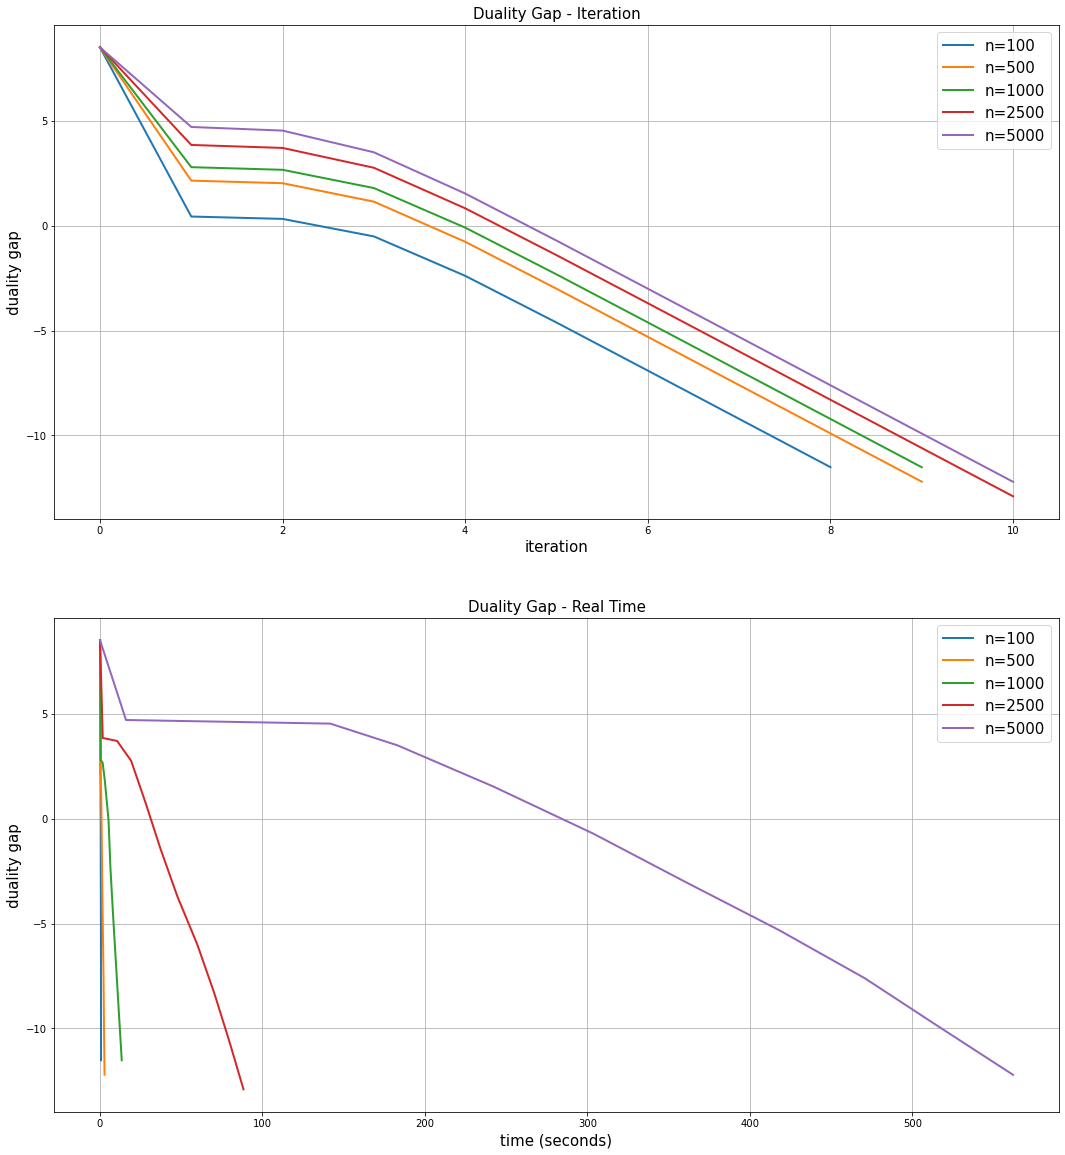

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(18, 20))

for n in tqdm(Ns):
    h = shapes_n[n]
    axes[0].plot(np.arange(len(h['time'])), np.log(h['duality_gap']), label='n={0}'.format(n), linewidth=2)
    axes[1].plot(h['time'], np.log(h['duality_gap']), label='n={0}'.format(n), linewidth=2)

axes[0].set_xlabel('iteration', fontsize=fs)
axes[0].set_title('Duality Gap - Iteration', fontsize=fs)

axes[1].set_xlabel('time (seconds)', fontsize=fs)
axes[1].set_title('Duality Gap - Real Time', fontsize=fs)

for ax in axes:
    ax.set_ylabel('duality gap', fontsize=fs)
    ax.legend(fontsize=fs)
    ax.grid()

plt.show()
fig.savefig('n.png') 